In [ ]:
# Optimized model feature engineering
# Looking for additional features to boost model's predictive performance

In [ ]:
# Network efficiency measures

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx

# Load the baseline data
baseline_data = pd.read_csv("baseline_model_data.csv")

# Prepare the network efficiency DataFrame using existing participant IDs and general psychopathology scores
network_efficiency = baseline_data[["participant_id", "general_psychopathology"]].copy()

# Define networks and tasks
networks = {
    "default mode network": "default",
    "dorsal attention network": "dorsal",
    "frontoparietal control network": "frontoparietal",
    "limbic network": "limbic",
    "salience network": "salience"
}
tasks = {
    "Resting-State": ["rest_AP_run01", "rest_AP_run02", "rest_PA_run01", "rest_PA_run02"],
    "Hammer": ["hammer_AP_run01"],
    "Stroop": ["stroop_AP_run01", "stroop_PA_run01"]
}

# Function to compute network efficiency
def compute_efficiency(fc_matrix):
    # Step 1: Zero out the diagonal to remove self-connections
    np.fill_diagonal(fc_matrix, 0)

    # Step 2: Threshold to retain significant connections
    threshold = 0.3
    fc_matrix = np.where(np.abs(fc_matrix) > threshold, fc_matrix, 0)
    
    # Convert FC matrix to a graph (retaining absolute weights)
    graph = nx.from_numpy_array(fc_matrix)
    
    # Compute and return global efficiency
    return nx.global_efficiency(graph)

# Initialize efficiency columns for each task-network combination
for task in tasks.keys():
    for network in networks.keys():
        network_efficiency[f"{task}_{network}_efficiency"] = np.nan

# Base directory for FC matrices
base_dir = "Network FC matrices"

# Compute network efficiency for each participant, task, and network
for _, row in network_efficiency.iterrows():
    participant_id = row["participant_id"]
    for task_name, runs in tasks.items():
        for network_full, network_short in networks.items():
            network_dir = os.path.join(base_dir, network_full)
            
            task_efficiencies = []
            for run in runs:
                file_path = os.path.join(network_dir, run, f"{participant_id}_{network_short}_FC_matrix.npy")
                if os.path.exists(file_path):
                    fc_matrix = np.load(file_path)
                    
                    # Compute network efficiency using absolute weights
                    efficiency = compute_efficiency(fc_matrix)
                    task_efficiencies.append(efficiency)
            
            # Compute and assign average efficiency across runs
            if task_efficiencies:
                network_efficiency.loc[
                    network_efficiency["participant_id"] == participant_id,
                    f"{task_name}_{network_full}_efficiency"
                ] = np.mean(task_efficiencies)

# Save the results DataFrame
# network_efficiency.to_csv("network_efficiency.csv", index=False)

# Display for confirmation
print(network_efficiency.head())


     participant_id  general_psychopathology  \
0  NDAR_INVDW733XXB                96.923340   
1  NDAR_INVEV975LY3               119.803520   
2  NDAR_INVKV870NBK               113.809580   
3  NDAR_INVXJ707NAE                76.470000   
4  NDAR_INVWD467AR0                85.819786   

   Resting-State_default mode network_efficiency  \
0                                       0.626812   
1                                       0.501459   
2                                       0.378793   
3                                       0.523809   
4                                       0.585707   

   Resting-State_dorsal attention network_efficiency  \
0                                           0.662645   
1                                           0.524463   
2                                           0.615212   
3                                           0.608849   
4                                           0.651081   

   Resting-State_frontoparietal control network_efficiency  \

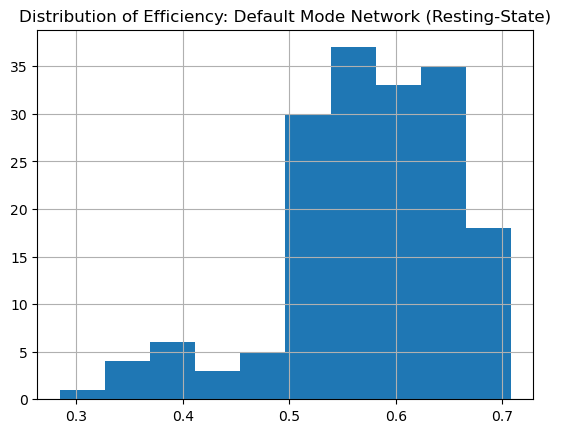

In [20]:
import matplotlib.pyplot as plt
network_efficiency['Resting-State_default mode network_efficiency'].hist()
plt.title('Distribution of Efficiency: Default Mode Network (Resting-State)')
plt.show()


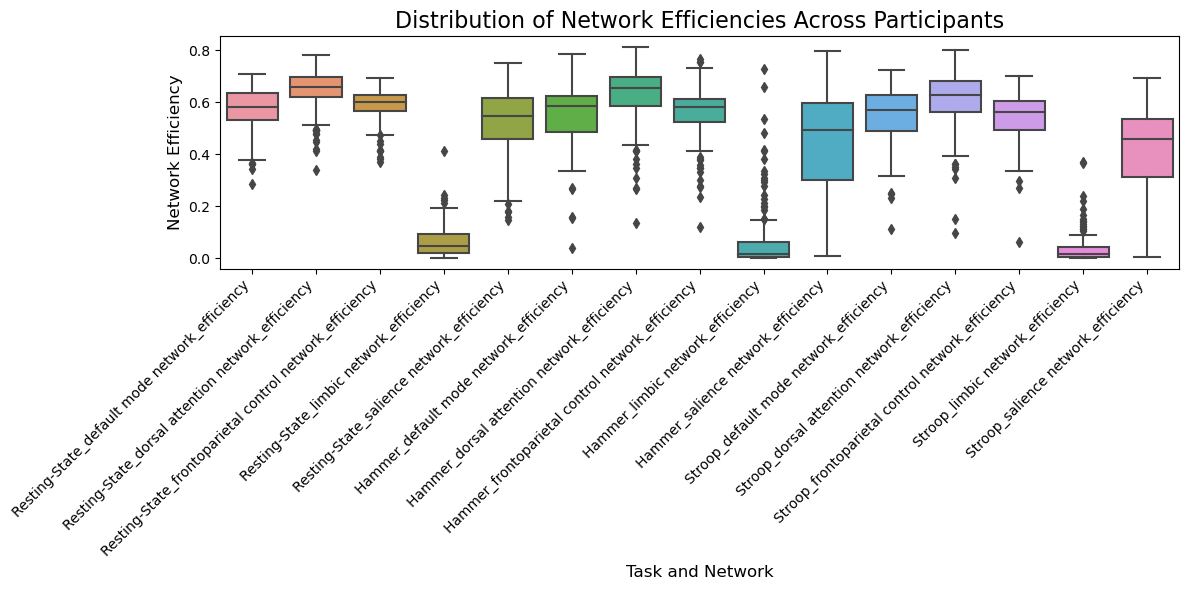

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame for easier plotting
melted_df = network_efficiency.melt(id_vars=["participant_id", "general_psychopathology"], 
                                    var_name="Task_Network", 
                                    value_name="Efficiency")

# Create boxplots for efficiency across networks and tasks
plt.figure(figsize=(12, 6))
sns.boxplot(x="Task_Network", y="Efficiency", data=melted_df)
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Network Efficiencies Across Participants", fontsize=16)
plt.ylabel("Network Efficiency", fontsize=12)
plt.xlabel("Task and Network", fontsize=12)
plt.tight_layout()
plt.show()


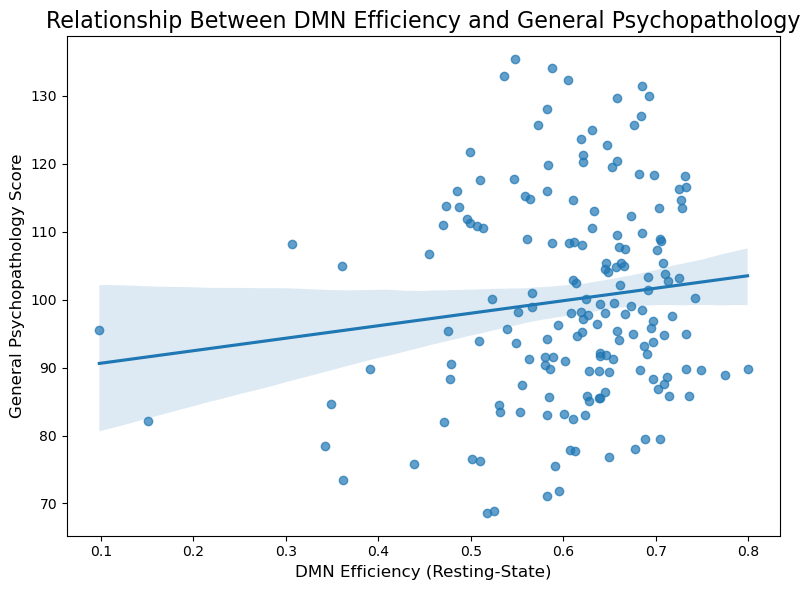

In [ ]:
# Scatter plot for one network-task combination
plt.figure(figsize=(8, 6))
sns.regplot(x="Stroop_dorsal attention network_efficiency", 
            y="general_psychopathology", 
            data=network_efficiency, 
            scatter_kws={'alpha': 0.7})
plt.title("Relationship Between DMN Efficiency and General Psychopathology", fontsize=16)
plt.xlabel("DAN Efficiency (Stroop)", fontsize=12)
plt.ylabel("General Psychopathology Score", fontsize=12)
plt.tight_layout()
plt.show()


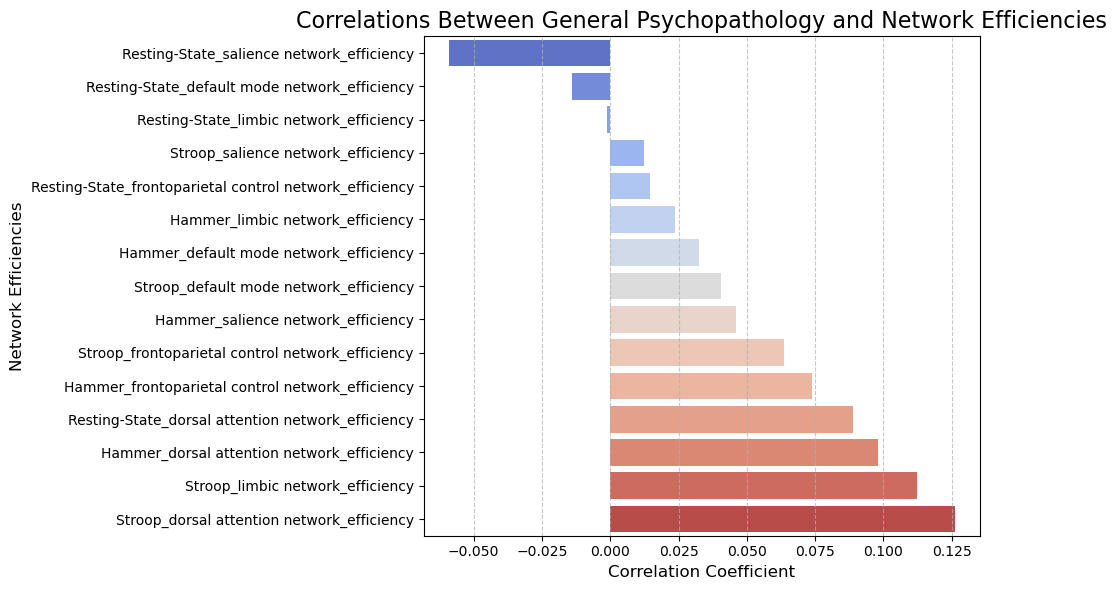

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlations between general psychopathology and all network efficiencies
correlations = network_efficiency.drop(columns=["participant_id"]).corr()["general_psychopathology"]

# Filter out only the network efficiency correlations
efficiency_correlations = correlations.drop("general_psychopathology")

# Sort the correlations for better visualization
efficiency_correlations = efficiency_correlations.sort_values()

# Plot the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=efficiency_correlations.values, y=efficiency_correlations.index, palette="coolwarm", orient="h")
plt.title("Correlations Between General Psychopathology and Network Efficiencies", fontsize=16)
plt.xlabel("Correlation Coefficient", fontsize=12)
plt.ylabel("Network Efficiencies", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Global efficiencies per task

In [25]:
# Load the 'optimized_model_data.csv' file
optimized_model_data_path = 'optimized_model_data.csv'
optimized_model_data = pd.read_csv(optimized_model_data_path)

# Merge 'network_efficiency' with 'optimized_model_data' based on 'participant_id' and 'general_psychopathology'
merged_data = pd.merge(
    optimized_model_data,
    network_efficiency,
    on=['participant_id', 'general_psychopathology'],
    how='left'  # Using left join to preserve all rows from optimized_model_data
)

# Save the updated DataFrame back to a new CSV file
output_path = 'work_model_data.csv'
merged_data.to_csv(output_path, index=False)

# Display a confirmation message
output_path


'work_model_data.csv'

In [3]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from scipy.sparse import csr_matrix

# Load baseline data
baseline_data = pd.read_csv("baseline_model_data.csv")

# Prepare DataFrame for global efficiency measures
global_efficiency = baseline_data[["participant_id", "general_psychopathology"]].copy()

# Define tasks
tasks = {
    "Resting-State": ["rest_AP_run01", "rest_AP_run02", "rest_PA_run01", "rest_PA_run02"],
    "Hammer": ["hammer_AP_run01"],
    "Stroop": ["stroop_AP_run01", "stroop_PA_run01"]
}

# Base directory for full FC matrices
base_dir = "full FC matrices"
thresholded_dir = "thresholded_FC_matrices"

# Step 1: Pre-threshold FC matrices and save them
def pre_threshold_fc_matrix(input_path, output_path, threshold=0.3):
    """
    Thresholds the functional connectivity matrix and saves the result.
    """
    # Load the full FC matrix
    fc_matrix = np.load(input_path)
    np.fill_diagonal(fc_matrix, 0)
    fc_matrix = np.where(np.abs(fc_matrix) > threshold, fc_matrix, 0)
    
    # Save the thresholded matrix
    np.save(output_path, fc_matrix)

# Pre-threshold all FC matrices
if not os.path.exists(thresholded_dir):
    os.makedirs(thresholded_dir)
    for root, _, files in os.walk(base_dir):
        for filename in files:
            if filename.endswith("_full_FC_matrix.npy"):
                input_path = os.path.join(root, filename)
                relative_path = os.path.relpath(root, base_dir)
                output_dir = os.path.join(thresholded_dir, relative_path)
                os.makedirs(output_dir, exist_ok=True)
                output_path = os.path.join(output_dir, filename)
                pre_threshold_fc_matrix(input_path, output_path)

# Step 2: Compute global efficiency using sparse graph representation
def compute_global_efficiency_sparse(fc_matrix):
    """
    Computes global efficiency using a sparse graph representation.
    """
    # Convert FC matrix to sparse graph
    sparse_matrix = csr_matrix(fc_matrix)
    graph = nx.from_scipy_sparse_array(sparse_matrix)
    return nx.global_efficiency(graph)

# Initialize columns for global efficiency of each task
for task in tasks.keys():
    global_efficiency[f"{task}_global_efficiency"] = np.nan

# Compute global efficiency for each participant and task
for _, row in global_efficiency.iterrows():
    participant_id = row["participant_id"]
    
    for task_name, runs in tasks.items():
        task_efficiencies = []
        
        for run in runs:
            # Path to the pre-thresholded FC matrix file
            file_path = os.path.join(thresholded_dir, run, f"{participant_id}_full_FC_matrix.npy")
            
            if os.path.exists(file_path):
                # Load the pre-thresholded FC matrix
                thresholded_fc_matrix = np.load(file_path)
                
                # Compute global efficiency
                efficiency = compute_global_efficiency_sparse(thresholded_fc_matrix)
                task_efficiencies.append(efficiency)
        
        # Assign the average global efficiency across runs
        if task_efficiencies:
            global_efficiency.loc[
                global_efficiency["participant_id"] == participant_id,
                f"{task_name}_global_efficiency"
            ] = np.mean(task_efficiencies)

# Save the global efficiency results to a CSV file
global_efficiency.to_csv("global_efficiency_results.csv", index=False)

# Display the first few rows for confirmation
print(global_efficiency.head())


     participant_id  general_psychopathology  Resting-State_global_efficiency  \
0  NDAR_INVDW733XXB                96.923340                         0.406690   
1  NDAR_INVEV975LY3               119.803520                         0.330435   
2  NDAR_INVKV870NBK               113.809580                         0.408703   
3  NDAR_INVXJ707NAE                76.470000                         0.372248   
4  NDAR_INVWD467AR0                85.819786                         0.482549   

   Hammer_global_efficiency  Stroop_global_efficiency  
0                  0.418582                  0.418110  
1                  0.270845                  0.371815  
2                  0.351260                  0.316136  
3                  0.248683                  0.185656  
4                  0.328777                  0.359324  


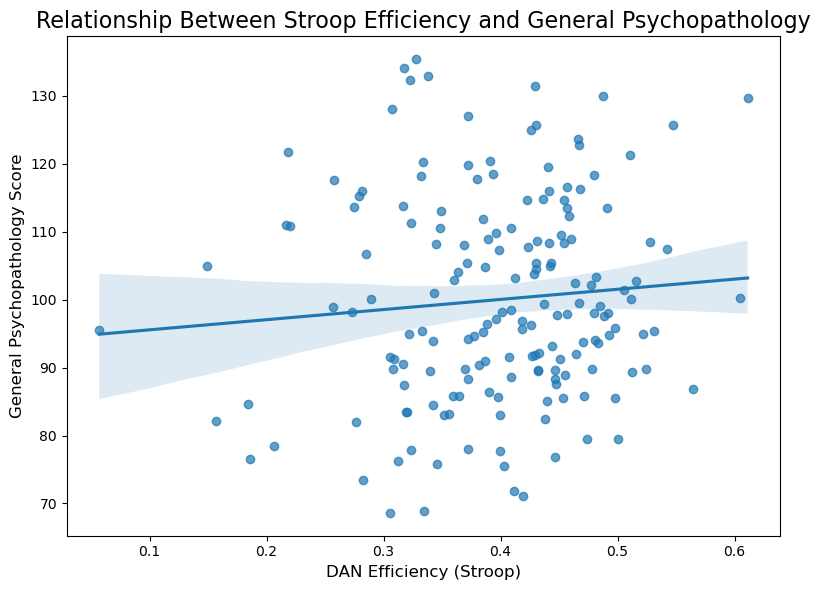

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the computed global efficiency data
global_efficiency = pd.read_csv("global_efficiency_results.csv")

# Scatter plot for one network-task combination
plt.figure(figsize=(8, 6))
sns.regplot(x="Stroop_global_efficiency", 
            y="general_psychopathology", 
            data=global_efficiency, 
            scatter_kws={'alpha': 0.7})
plt.title("Relationship Between Stroop Efficiency and General Psychopathology", fontsize=16)
plt.xlabel("DAN Efficiency (Stroop)", fontsize=12)
plt.ylabel("General Psychopathology Score", fontsize=12)
plt.tight_layout()
plt.show()



Correlations Between Global Efficiencies and General Psychopathology:
                                 Correlation   p-value
Resting-State_global_efficiency    -0.016545  0.829439
Hammer_global_efficiency            0.054316  0.479146
Stroop_global_efficiency            0.087526  0.253571


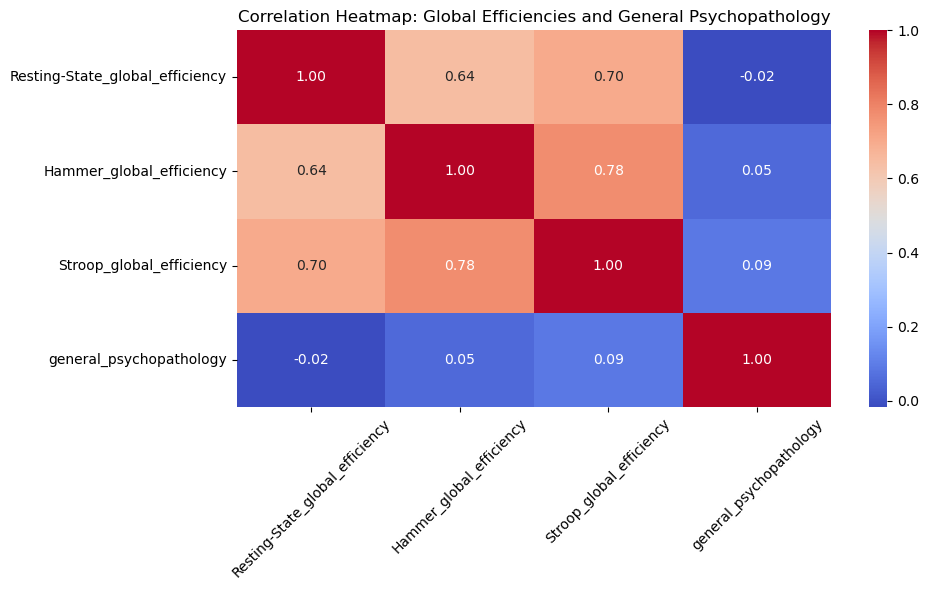


Regression Results Between Global Efficiencies and General Psychopathology:
                         Predictor  R-squared   p-value       Coef
2         Stroop_global_efficiency   0.007661  0.253571  14.922888
1         Hammer_global_efficiency   0.002950  0.479146   7.200354
0  Resting-State_global_efficiency   0.000274  0.829439  -3.651284


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import pearsonr

# 1. Correlations Between Global Efficiencies and General Psychopathology
efficiency_columns = [col for col in global_efficiency.columns if "_global_efficiency" in col]
correlation_results = {}

for col in efficiency_columns:
    corr, p_value = pearsonr(global_efficiency[col], global_efficiency["general_psychopathology"])
    correlation_results[col] = {"Correlation": corr, "p-value": p_value}

# Display correlations
correlation_df = pd.DataFrame(correlation_results).T
print("\nCorrelations Between Global Efficiencies and General Psychopathology:")
print(correlation_df)

# Visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(
    global_efficiency[efficiency_columns + ["general_psychopathology"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Correlation Heatmap: Global Efficiencies and General Psychopathology")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Regression Models
# Fit regression models for each global efficiency measure
regression_results = []

for col in efficiency_columns:
    X = global_efficiency[[col]].dropna()
    X = sm.add_constant(X)  # Add intercept
    y = global_efficiency.loc[X.index, "general_psychopathology"]

    model = sm.OLS(y, X).fit()
    regression_results.append({
        "Predictor": col,
        "R-squared": model.rsquared,
        "p-value": model.pvalues[col],
        "Coef": model.params[col]
    })

# Convert regression results to a DataFrame
regression_df = pd.DataFrame(regression_results)

print("\nRegression Results Between Global Efficiencies and General Psychopathology:")
print(regression_df.sort_values(by="R-squared", ascending=False))

In [10]:
import pandas as pd

# Load the CSV files
work_model_data = pd.read_csv("work_model_data.csv")
global_efficiency = pd.read_csv("global_efficiency_results.csv")

# Merge the datasets on 'participant_id' and 'general_psychopathology'
merged_data = pd.merge(
    work_model_data,
    global_efficiency[["participant_id", "general_psychopathology", 
                            "Resting-State_global_efficiency", 
                            "Hammer_global_efficiency", 
                            "Stroop_global_efficiency"]],
    on=["participant_id", "general_psychopathology"],
    how="left"  # Use "left" to retain all rows from work_model_data
)

# Display the first few rows to confirm the merge
print("Merged dataset preview:")
print(merged_data.head())

# Save the updated dataset to a new CSV file
merged_data.to_csv("work_model_data.csv", index=False)



Merged dataset preview:
     participant_id  general_psychopathology  \
0  NDAR_INVDW733XXB                96.923340   
1  NDAR_INVEV975LY3               119.803520   
2  NDAR_INVKV870NBK               113.809580   
3  NDAR_INVXJ707NAE                76.470000   
4  NDAR_INVWD467AR0                85.819786   

   Resting-State_default mode network_AVG  \
0                               13.646667   
1                               13.201064   
2                                8.893670   
3                               17.706718   
4                               13.711805   

   Resting-State_dorsal attention network_AVG  \
0                                   13.059157   
1                                    9.820026   
2                                   11.173023   
3                                   10.484619   
4                                   11.928479   

   Resting-State_frontoparietal control network_AVG  \
0                                          8.299604   
1          

In [ ]:
# Computing between-network average connectivity

In [ ]:
# First re-create a dictionary containing all ROIs per network

import pandas as pd

# Define the file path again and load the data
file_path = 'Schaefer2018_400_17N_Tian32_Buckner7hemi_FSLMNI152_2mm_labels.csv'
fc_data_info = pd.read_csv(file_path)

# Initialize dictionary to store the ROI indices for each network
networks_of_interest = {
    "default mode network": ["DefaultA", "DefaultB", "DefaultC"],
    "salience network": ["SalVentAttnA", "SalVentAttnB"],
    "frontoparietal control network": ["ContA", "ContB", "ContC"],
    "limbic network": ["LimbicA", "LimbicB"],
    "dorsal attention network": ["DorsAttnA", "DorsAttnB"]
}

# Initialize dictionary to store the ROI indices for each network
network_rois = {network: [] for network in networks_of_interest}

# Loop through each ROI and assign to the correct network based on the ROI name
for index, row in fc_data_info.iterrows():
    roi_name = row["ROI Name"]
    roi_index = row["ROI Label"] 
    
    for network, keywords in networks_of_interest.items():
        if any(keyword in roi_name for keyword in keywords):
            network_rois[network].append(roi_index)

# initializing limbic system ROIs lists (both included and excluded)
limbic_included = [401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 412, 413, 415,
                   417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 428, 429, 431]
limbic_excluded = [411, 414, 416, 427, 430, 432]

# Append included ROIs to the limbic network
network_rois["limbic network"].extend(limbic_included)

# Display the resulting dictionaries for the limbic network and all network ROIs
network_rois, limbic_included, limbic_excluded


({'default mode network': [149,
   150,
   151,
   152,
   153,
   154,
   155,
   156,
   157,
   158,
   159,
   160,
   161,
   162,
   163,
   164,
   165,
   166,
   167,
   168,
   169,
   170,
   171,
   172,
   173,
   174,
   175,
   176,
   177,
   178,
   179,
   180,
   181,
   182,
   183,
   184,
   185,
   186,
   187,
   188,
   189,
   190,
   191,
   192,
   193,
   194,
   358,
   359,
   360,
   361,
   362,
   363,
   364,
   365,
   366,
   367,
   368,
   369,
   370,
   371,
   372,
   373,
   374,
   375,
   376,
   377,
   378,
   379,
   380,
   381,
   382,
   383,
   384,
   385,
   386,
   387,
   388,
   389,
   390],
  'salience network': [86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   285,
   286,
   287,
   288,
   289,
   290,
   291,
   292,
   293,
   294,
   295,
   296,
   297,
   298,
   299,
   300,
   301,
   302,
   303,
 

In [ ]:
# Computing all FC matrices for selected network pairs

import os
import numpy as np

def compute_between_network_fc_matrices(network_pairs, network_rois, input_dir='full FC matrices', output_dir='Network FC matrices'):
    """
    Computes the FC matrices for pairs of networks across all participants and saves them
    in folders named after the network pairs, preserving the input subdirectory structure.
    
    Parameters:
    network_pairs (list): List of tuples specifying network pairs (e.g., [('default mode network', 'frontoparietal control network')]).
    network_rois (dict): Dictionary mapping network names to their ROI indices.
    input_dir (str): Base directory containing full FC matrix files with subdirectories for each run.
    output_dir (str): Base directory to save between-network FC matrices, organized by network pairs.
    """
    # Loop through each network pair
    for network1, network2 in network_pairs:
        # Define ROI indices for the two networks
        if network1 not in network_rois or network2 not in network_rois:
            raise ValueError(f"ROI indices not found for networks: {network1}, {network2}")
        roi_indices_network1 = network_rois[network1]
        roi_indices_network2 = network_rois[network2]
        
        # Create an output folder for the network pair (e.g., 'default_frontoparietal')
        pair_folder_name = f"{network1.split()[0].lower()}_{network2.split()[0].lower()}"
        pair_output_base_dir = os.path.join(output_dir, pair_folder_name)
        os.makedirs(pair_output_base_dir, exist_ok=True)
        
        # Walk through each subdirectory and file in the input directory
        for root, _, files in os.walk(input_dir):
            for filename in files:
                if filename.endswith('_full_FC_matrix.npy'):
                    # Construct the full path to the input FC matrix file
                    full_fc_path = os.path.join(root, filename)
                    
                    # Load the full FC matrix
                    full_fc_matrix = np.load(full_fc_path)
                    
                    # Extract the submatrix for the between-network pair
                    between_network_fc_matrix = full_fc_matrix[np.ix_(roi_indices_network1, roi_indices_network2)]
                    
                    # Extract the participant ID from the filename
                    participant_id = filename.split('_full_FC_matrix.npy')[0]
                    
                    # Preserve the subdirectory structure within the network pair's output folder
                    relative_subdir = os.path.relpath(root, input_dir)
                    output_subdir = os.path.join(pair_output_base_dir, relative_subdir)
                    os.makedirs(output_subdir, exist_ok=True)
                    
                    # Generate the output filename and path within the correct subdirectory
                    output_filename = f"{participant_id}_{network1.split()[0].lower()}_{network2.split()[0].lower()}_FC_matrix.npy"
                    output_path = os.path.join(output_subdir, output_filename)
                    
                    # Save the between-network FC matrix
                    np.save(output_path, between_network_fc_matrix)
                    print(f"Saved {output_filename} in {output_subdir}")

# Example usage
if __name__ == "__main__":
    # Define the network pairs
    network_pairs = [
        ("default mode network", "frontoparietal control network"),
        ("salience network", "default mode network"),
        ("frontoparietal control network", "dorsal attention network"),
        ("limbic network", "salience network"),
        ("default mode network", "dorsal attention network")
    ]

    # Compute and save between-network FC matrices
    compute_between_network_fc_matrices(network_pairs, network_rois, input_dir='full FC matrices', output_dir='Network FC matrices')


Saved NDAR_INVAG023WG3_default_frontoparietal_FC_matrix.npy in Network FC matrices\default_frontoparietal\hammer_AP_run01
Saved NDAR_INVAG388HJL_default_frontoparietal_FC_matrix.npy in Network FC matrices\default_frontoparietal\hammer_AP_run01
Saved NDAR_INVAG900RVD_default_frontoparietal_FC_matrix.npy in Network FC matrices\default_frontoparietal\hammer_AP_run01
Saved NDAR_INVAH529JMM_default_frontoparietal_FC_matrix.npy in Network FC matrices\default_frontoparietal\hammer_AP_run01
Saved NDAR_INVAK834VNU_default_frontoparietal_FC_matrix.npy in Network FC matrices\default_frontoparietal\hammer_AP_run01
Saved NDAR_INVAL101MH2_default_frontoparietal_FC_matrix.npy in Network FC matrices\default_frontoparietal\hammer_AP_run01
Saved NDAR_INVAP729WCD_default_frontoparietal_FC_matrix.npy in Network FC matrices\default_frontoparietal\hammer_AP_run01
Saved NDAR_INVAT097DFG_default_frontoparietal_FC_matrix.npy in Network FC matrices\default_frontoparietal\hammer_AP_run01
Saved NDAR_INVAZ218MB7_d

In [13]:
import os
import numpy as np
import pandas as pd

# Paths
base_dir = "Network FC matrices"
data_file = "work_model_data.csv"

# Define network pairs and tasks
network_pairs = [
    ("default mode network", "frontoparietal control network"),
    ("salience network", "default mode network"),
    ("frontoparietal control network", "dorsal attention network"),
    ("limbic network", "salience network"),
    ("default mode network", "dorsal attention network")
]
tasks = {
    "Resting-State": ["rest_AP_run01", "rest_AP_run02", "rest_PA_run01", "rest_PA_run02"],
    "Hammer": ["hammer_AP_run01"],
    "Stroop": ["stroop_AP_run01", "stroop_PA_run01"]
}

# Load participant IDs from work_model_data.csv
work_model_data = pd.read_csv(data_file)
results_df = pd.DataFrame({"participant_id": work_model_data["participant_id"]})

# Initialize missing file counter
missing_count = 0

# Iterate through participants in the dataset
for participant_id in work_model_data["participant_id"]:
    # Create a dictionary to hold computed values for this participant
    participant_results = {}

    for task_name, runs in tasks.items():
        for network1, network2 in network_pairs:
            # Generate folder name for the network pair
            network1_short = network1.split()[0].lower()
            network2_short = network2.split()[0].lower()
            network_pair_folder = f"{network1_short}_{network2_short}"
            network_pair_dir = os.path.join(base_dir, network_pair_folder)

            # Gather all FC matrices for the participant, task, and network pair
            task_matrices = []
            for run in runs:
                file_path = os.path.join(
                    network_pair_dir, run, f"{participant_id}_{network1_short}_{network2_short}_FC_matrix.npy"
                )
                print(f"Looking for file: {file_path}")
                if os.path.exists(file_path):
                    fc_matrix = np.load(file_path)

                    degree_strength = np.sum(fc_matrix, axis=1)  # Sum across rows
                    average_degree_strength = np.mean(degree_strength)  # Average row-wise degree strength
                    task_matrices.append(average_degree_strength)
                else:
                    print(f"File missing: {file_path}")
                    missing_count += 1

            # Compute average across all runs for this task and network pair
            col_name = f"{task_name}_{network1_short}_{network2_short}"
            if task_matrices:
                participant_results[col_name] = np.mean(task_matrices)
            else:
                participant_results[col_name] = np.nan

        # Update `results_df` for this participant based on `participant_id`
        for col_name, value in participant_results.items():
            if col_name not in results_df.columns:
                results_df[col_name] = np.nan
            results_df.loc[results_df["participant_id"] == participant_id, col_name] = value

print(f"Total missing files: {missing_count}")

# Save the results to a CSV file
# results_df.to_csv("between_network_avg_connectivity_results.csv", index=False)

# Display the DataFrame for confirmation
print("Computed Results:")
print(results_df.head())


Looking for file: Network FC matrices\default_frontoparietal\rest_AP_run01\NDAR_INVDW733XXB_default_frontoparietal_FC_matrix.npy
Looking for file: Network FC matrices\default_frontoparietal\rest_AP_run02\NDAR_INVDW733XXB_default_frontoparietal_FC_matrix.npy
Looking for file: Network FC matrices\default_frontoparietal\rest_PA_run01\NDAR_INVDW733XXB_default_frontoparietal_FC_matrix.npy
Looking for file: Network FC matrices\default_frontoparietal\rest_PA_run02\NDAR_INVDW733XXB_default_frontoparietal_FC_matrix.npy
Looking for file: Network FC matrices\salience_default\rest_AP_run01\NDAR_INVDW733XXB_salience_default_FC_matrix.npy
Looking for file: Network FC matrices\salience_default\rest_AP_run02\NDAR_INVDW733XXB_salience_default_FC_matrix.npy
Looking for file: Network FC matrices\salience_default\rest_PA_run01\NDAR_INVDW733XXB_salience_default_FC_matrix.npy
Looking for file: Network FC matrices\salience_default\rest_PA_run02\NDAR_INVDW733XXB_salience_default_FC_matrix.npy
Looking for file

In [15]:
# Columns with missing values
missing_columns = [
    "Stroop_default_frontoparietal",
    "Stroop_frontoparietal_dorsal",
    "Stroop_limbic_salience"
]

# Find participant IDs with missing values in the specified columns
for col in missing_columns:
    missing_ids = results_df.loc[results_df[col].isnull(), "participant_id"]
    print(f"Missing values for column '{col}':")
    print(missing_ids.tolist())
    print()

Missing values for column 'Stroop_default_frontoparietal':
['NDAR_INVHW100CDA']

Missing values for column 'Stroop_frontoparietal_dorsal':
['NDAR_INVHW100CDA']

Missing values for column 'Stroop_limbic_salience':
['NDAR_INVHW100CDA']



In [ ]:
# Separately compute the pairwise AVG degree strength for the missing values

import os
import numpy as np
import pandas as pd

# Paths to the base directory and participant ID
base_dir = "Network FC matrices"
participant_id = "NDAR_INVHW100CDA"

# Networks to fix and their corresponding short names
networks_to_fix = {
    "default mode network": "default",
    "frontoparietal control network": "frontoparietal",
    "limbic network": "limbic",
    "salience network": "salience",
    "dorsal attention network": "dorsal"
}

# Missing columns and associated network pairs
columns_to_fix = {
    "Stroop_default_frontoparietal": ("default", "frontoparietal"),
    "Stroop_frontoparietal_dorsal": ("frontoparietal", "dorsal"),
    "Stroop_limbic_salience": ("limbic", "salience")
}

# Stroop task runs
stroop_runs = ["stroop_AP_run01", "stroop_PA_run01"]

# Compute averages for the missing values
for column_name, (network1_short, network2_short) in columns_to_fix.items():
    task_matrices = []
    network_pair_folder = f"{network1_short}_{network2_short}"

    for run in stroop_runs:
        file_path = os.path.join(base_dir, network_pair_folder, run, f"{participant_id}_{network1_short}_{network2_short}_FC_matrix.npy")
        print(f"Checking file: {file_path}")
        
        if os.path.exists(file_path):
            try:
                fc_matrix = np.load(file_path)
                print(f"Matrix shape: {fc_matrix.shape}, Min: {np.nanmin(fc_matrix)}, Max: {np.nanmax(fc_matrix)}")
                
                # Handle NaN values in the matrix
                fc_matrix = np.nan_to_num(fc_matrix, nan=0.0)
                
                degree_strength = np.sum(fc_matrix, axis=1)
                average_degree_strength = np.mean(degree_strength)
                task_matrices.append(average_degree_strength)
                print(f"Degree strength for {run} in {column_name}: {average_degree_strength}")
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
        else:
            print(f"File missing: {file_path}")
    
    # Compute the average across runs
    if task_matrices:
        average_value = np.mean(task_matrices)
        print(f"Computed average for {column_name}: {average_value}")
        
        # Update the DataFrame
        results_df.loc[results_df["participant_id"] == participant_id, column_name] = average_value
    else:
        print(f"No data available for {column_name}. Cannot compute average.")

# Save the updated DataFrame
# results_df.to_csv("between_network_avg_connectivity_results_imputed.csv", index=False)

# Confirm the changes
updated_values = results_df.loc[results_df["participant_id"] == participant_id, columns_to_fix.keys()]
print(f"Updated values for participant {participant_id}:")
print(updated_values)



Checking file: Network FC matrices\default_frontoparietal\stroop_AP_run01\NDAR_INVHW100CDA_default_frontoparietal_FC_matrix.npy
Matrix shape: (79, 61), Min: -0.6168938279151917, Max: 0.898564338684082
Degree strength for stroop_AP_run01 in Stroop_default_frontoparietal: 0.9808089733123779
Checking file: Network FC matrices\default_frontoparietal\stroop_PA_run01\NDAR_INVHW100CDA_default_frontoparietal_FC_matrix.npy
Matrix shape: (79, 61), Min: -0.9749958515167236, Max: 0.9809412360191345
Degree strength for stroop_PA_run01 in Stroop_default_frontoparietal: 2.5864570140838623
Computed average for Stroop_default_frontoparietal: 1.7836329936981201
Checking file: Network FC matrices\frontoparietal_dorsal\stroop_AP_run01\NDAR_INVHW100CDA_frontoparietal_dorsal_FC_matrix.npy
Matrix shape: (61, 52), Min: -0.5985886454582214, Max: 0.7525338530540466
Degree strength for stroop_AP_run01 in Stroop_frontoparietal_dorsal: 1.4135769605636597
Checking file: Network FC matrices\frontoparietal_dorsal\str

In [23]:
import pandas as pd

# Load the original work_model_data file
work_model_data = pd.read_csv("work_model_data.csv")
print("Dimensions of work_model_data before appending:", work_model_data.shape)

# Merge the two DataFrames on participant_id
updated_work_model_data = pd.merge(work_model_data, results_df, on="participant_id", how="left")

# Show the dimensions of the updated DataFrame
print("Dimensions of work_model_data after appending:", updated_work_model_data.shape)

# Save the updated DataFrame
updated_work_model_data.to_csv("work_model_data.csv", index=False)
print("Updated work_model_data.csv saved successfully.")


Dimensions of work_model_data before appending: (172, 35)
Dimensions of work_model_data after appending: (172, 50)
Updated work_model_data.csv saved successfully.
